# The Problem
## Santander Customer Transaction Prediction
### Can you identify who will make a transaction?
    Santander is a commercial bank present predominantly in the Europe and extending their reach to North America, South America and Asia. Being a banking institution it is vital to understand any given customer's transaction patterns, spending reports to be able to offer an array of other services. In an effort to do so, Santander has hosted a competition on Kaggle expecting Kagglers to design a model to predict if a customer transacts given a set of features. 
    The catch is, banks couldn't usually provide customers data publically and hence they have anonymised all the features and put together train file with 200000 datapoints, 200 columns without specifying what each column means.

# Importing Librabies

In [4]:
import random
import math
import numpy as np
import pandas as pd
import time
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
import lightgbm 
from sklearn.model_selection import RandomizedSearchCV, StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc


# Reading Data

In [5]:
train = pd.read_csv('/Users/gurumanikanta/Documents/DS-Analytics/SupervisedLearning/DataTales/santander-customer-transaction-prediction/SantanderData/train.csv')
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


    using a 300MB dataset is not a problem for the computers these days, but lower the memmory usage the better
    I will try to use simple hacks to reduce the memory usage

In [6]:
pd.value_counts(train.dtypes)

float64    200
object       1
int64        1
dtype: int64

In [7]:
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',210)
desc = train.describe()
print("Minimum value: {} \nMaximum value: {}".format(min(desc.loc['min',:]),max(desc.loc['max',:])))

Minimum value: -90.2525 
Maximum value: 74.0321


    It is pretty clear from the max and min values of all the columns that inputs do not exceed the range of float32 itself so we can convert the bit size to float32 from float64

In [8]:
#ID_code(object) and target(int64) are the only fields that are not float64 type
print('Original Usage: ')
print(train[train.columns[2:]].info(memory_usage='deep',verbose=False))
print('Usage after reducing bits: ')
print(train[train.columns[2:]].astype('float32').info(memory_usage='deep',verbose=False))
#usage reduced by 50%
train[train.columns[2:]] = train[train.columns[2:]].astype('float32')


Original Usage: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 200 entries, var_0 to var_199
dtypes: float64(200)
memory usage: 305.2 MB
None
Usage after reducing bits: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 200 entries, var_0 to var_199
dtypes: float32(200)
memory usage: 152.6 MB
None


In [9]:
print('Original Usage: ',train['target'].memory_usage(deep=True))
print('Usage after reducing bits: ',train['target'].astype('int16').memory_usage(deep=True))
#usage reduced by 75%
train['target'] = train['target'].astype('int16')

Original Usage:  1600128
Usage after reducing bits:  400128


    Couldn't we convert all the variables to 16 or 8 bit? why did we stop at 32 bit itself?

    If I'm sure about the range of values in the future data, I can even reduce the bits to 16 for all the columns but we do not know what each column represents and hence could cause errors if used in a pipeline. 
    That's one handy method to reduce memory usage without hassle 

In [10]:
print(train[['ID_code']].info(verbose=False,memory_usage='deep'))
#this column is using 13MB when infact it doesn't play any role since it's just an identifier
#let's delete ID_code
train.drop(labels=['ID_code'],inplace=True,axis=1)
train.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 1 entries, ID_code to ID_code
dtypes: object(1)
memory usage: 13.1 MB
None


Index(['target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6',
       'var_7', 'var_8',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=201)

In [11]:
#We managed to reduce the memory used by 50%, that's a significant improvement
train.info(verbose=False,memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, target to var_199
dtypes: float32(200), int16(1)
memory usage: 153.0 MB


# Sampling, Hypothesis and Inference

In [12]:
random_sample = random.sample(population = range(len(train)),k=2000)
train_random = train.loc[random_sample,:]

#let's calculate some population parameters useful for hypothesis testing
pop_mean = train.iloc[:,1:].mean(axis=0)
pop_std = train.iloc[:,1:].std(axis=0)
pop_samples = len(train)

#sample statistics for hypothesis testing
sample_mean = train_random.iloc[:,1:].mean(axis=0)
sample_std = train_random.iloc[:,1:].mean(axis=0)
samples = len(train_random)
sample_se = sample_std/math.sqrt(samples)

In [13]:
#the ratio in actual data is also 80:20 for no_transaction to transaction
pd.value_counts(train_random['target'])
#for the purposes of hypothesis testing we will only use the train_random

0    1803
1     197
Name: target, dtype: int64

#### I am interested in checking the similarity of sample to the population. The most used ways to perform such action are z and t tests. 
    Which test do you think we should use and why?

    t-tests are preferred when the sample size is very small(less than 30) so I will go with the Z-test
## Z test
    Calculated by formula: (sample_mean - pop_mean)/pop_std. This will return a test statistic which when looked up in a Z-table gives us the p-value at given Z-score
    
    Since this is a test of similarity between 2 sets of data, hypothesis is as follows:
    h0: The sample and population have no differences in properties(essentially sample_mean = population_mean)
    h1: The sample doesn't belong to the population(sample_mean != population_mean)
    
    When I check for above hypothesis I would like to be 95% confident in the results and hence alpha = 5%(0.05)

In [14]:
#alpha is 0.05(0.025 on either side)
#1.96 is z on positive side at 0.975
#-1.96 is z on negative side at 0.025
z_scores = (sample_mean - pop_mean)/sample_se
#if our z score falls between -1.96 and 1.96 we fail to reject null hypothesis

In [15]:
mask = (z_scores>-1.96) & (z_scores<1.96)
ind = np.logical_not(mask)
np.where(ind)

(array([  8,  10,  11,  32,  39,  47,  52,  54,  65,  76,  82,  83,  99,
        122, 128, 135, 170, 171, 173, 178, 180, 182, 195, 199]),)

In [16]:
act_ind = ['var_'+str(val) for val in np.where(ind)[0]]
for val in z_scores[act_ind]:
    print(val)

#The above indeces are the ones where we reject null hypothesis

6.393463134765625
6.07524299621582
2.2042551040649414
3.894594192504883
-11.965348243713379
-1.9969576597213745
3.0497844219207764
-3.1485965251922607
2.7885870933532715
2.705721855163574
4.2184858322143555
-4.491328716278076
-2.8768880367279053
6.840839385986328
-4.642087459564209
-2.4145936965942383
87.43289184570312
10.665982246398926
6.332379341125488
3.311579942703247
-3.555495262145996
-76.37899780273438
-4.678475856781006
-2.1496386528015137


### Conclusion
    The idea of using hypothesis test here is: if our test had proven that all the columns from the sample are exact representation of the population, we can perform analysis on sample and infer the same to population as well. But now that it failed we will work on the whole population

### Let's look at the data

In [17]:
train.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,...,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.713301,10.535000,16.219101,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.666700,3.8743,-5.2387,7.3746,11.5767,12.0446,11.6418,-7.017000,5.9226,-14.213600,16.028299,5.325300,12.9194,29.0460,-0.6940,5.1736,-0.7474,14.832200,11.266800,5.3822,2.0183,10.1166,16.1828,4.9590,2.0771,-0.2154,8.6748,9.5319,5.8056,22.4321,5.0109,-4.7010,21.637400,0.5663,5.1999,8.860000,43.112701,18.381599,-2.3440,23.410400,6.5199,12.1983,13.6468,13.8372,1.3675,2.9423,-4.5213,21.466900,9.3225,16.4597,7.9984,-1.7069,-21.449400,6.7806,11.0924,9.9913,14.8421,0.1812,8.964200,16.257200,2.1743,...,9.476300,13.310200,26.5376,1.4403,14.7100,6.0454,9.5426,17.155399,14.1104,24.362700,2.0323,6.7602,3.9141,-0.4851,2.5240,1.5093,2.5516,15.575200,-13.4221,7.2739,16.009399,9.7268,0.8897,0.7754,4.2218,12.0039,13.8571,-0.7338,-1.9245,15.446200,12.8287,0.3587,9.6508,6.5674,5.1726,3.1345,29.454700,31.404499,2.8279,15.659900,8.3307,-5.6011,19.061399,11.2663,8.6989,8.3694,11.5659,-16.4727,4.0288,17.9244,18.517700,10.7800,9.0056,16.696400,10.4838,1.6573,12.1749,-13.1324,17.605400,11.5423,15.457600,5.3133,3.6159,5.0384,6.6760,12.664400,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.877300,3.1531,18.561800,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.839800,5.8764,11.8411,-19.7159,17.574301,0.5857,4.4354,3.9642,3.1364,1.6910,18.522699,-2.3978,7.8784,8.5635,12.780300,-1.0914
1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.570801,3.428700,2.740700,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,10.816000,3.6783,-11.1147,1.8730,9.8775,11.7842,1.2444,-47.379700,7.3718,0.194800,34.401402,25.703699,11.8343,13.2256,-4.1083,6.6885,-8.0946,18.599501,19.321899,7.0118,1.9210,8.8682,8.0109,-7.2417,1.7944,-1.3147,8.1042,1.5365,5.4007,7.9344,5.0220,2.2302,40.563202,0.5134,3.1701,20.106800,7.784100,7.052900,3.2709,23.482201,5.5075,13.7814,2.5462,18.1782,0.3683,-4.8210,-5.4850,13.786700,-13.5901,11.0993,7.9022,12.2301,0.476800,6.8852,8.0905,10.9631,11.7569,-1.2722,24.787600,26.688101,1.8944,...,-13.695000,8.406800,35.4734,1.7093,15.1866,2.6227,7.3412,32.088799,13.9550,13.085800,6.6203,7.1051,5.3523,8.5426,3.

([], <a list of 0 Text yticklabel objects>)

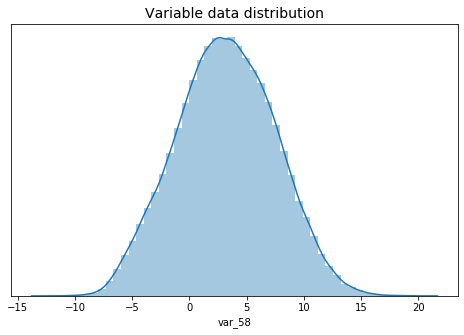

In [18]:
plt.figure(figsize=(8,5))
plt.title('Variable data distribution',fontsize=14)
sns.distplot(train['var_58'])
plt.yticks(ticks=[])


    After randomly looking at the distributions of various features, it seems like most variables are normally distributed or atleast almost normal

In [19]:
#calculating outliers per column
cols = train.columns.drop('target')
q1 = train[cols].quantile(.25)
q3 = train[cols].quantile(.75)
iqr = q3 - q1

((train[cols] < (q1 - 1.5*iqr)) | (train[cols] > (q3 + 1.5*iqr))).sum()

var_0       104
var_1         6
var_2        49
var_3        22
var_4        76
var_5         4
var_6       113
var_7        19
var_8         2
var_9         0
var_10      125
var_11      309
var_12       39
var_13        1
var_14        2
var_15       22
var_16       68
var_17      221
var_18       11
var_19        1
var_20        1
var_21      275
var_22      289
var_23       90
var_24        4
var_25      241
var_26      186
var_27        3
var_28      193
var_29      144
var_30       12
var_31      637
var_32        2
var_33        4
var_34       10
var_35      198
var_36      178
var_37        1
var_38      502
var_39      158
var_40       48
var_41        0
var_42       32
var_43       17
var_44     1208
var_45       41
var_46      268
var_47        2
var_48       95
var_49        7
var_50      222
var_51       42
var_52      353
var_53       27
var_54       38
var_55        0
var_56      254
var_57      145
var_58      401
var_59       53
var_60        5
var_61       56
var_62  

    Do you think using 3 IQR would help reduce the # outliers? If it does is it a good method and why?

    When Tukey introduced box and whisker plots in 1977, he had termed the >q3+1.5*iqr & <q1-1.5iqr as inner fence and >q3+3*iqr & <q1-3iqr as outer fence. So the values after inner fence are called outside and the ones after outer fence are called far out values. When working with large and not so skewed datasets, values outside inner fence are possible outliers and the ones outside outer fence are problamatic outliers.
    So, as long as our values fall inside the outer fence, we don't need to worry about them given the data distribution isn't skewed. Now, from our observation of variables randomly it is clear that the distributions are not skewed and hence we can consider values inside 3*iqr are not outliers

In [35]:
q1 = train[cols].quantile(.25)
q3 = train[cols].quantile(.75)
iqr = q3 - q1

((train[cols] < (q1 - 3*iqr)) | (train[cols] > (q3 + 3*iqr))).sum()

var_0      0
var_1      0
var_2      0
var_3      0
var_4      0
var_5      0
var_6      0
var_7      0
var_8      0
var_9      0
var_10     0
var_11     0
var_12     0
var_13     0
var_14     0
var_15     0
var_16     0
var_17     0
var_18     0
var_19     0
var_20     0
var_21     0
var_22     0
var_23     0
var_24     0
var_25     0
var_26     0
var_27     0
var_28     0
var_29     0
var_30     0
var_31     0
var_32     0
var_33     0
var_34     0
var_35     0
var_36     0
var_37     0
var_38     0
var_39     0
var_40     0
var_41     0
var_42     0
var_43     0
var_44     0
var_45     0
var_46     0
var_47     0
var_48     0
var_49     0
var_50     0
var_51     0
var_52     0
var_53     0
var_54     0
var_55     0
var_56     0
var_57     0
var_58     0
var_59     0
var_60     0
var_61     0
var_62     0
var_63     0
var_64     0
var_65     0
var_66     0
var_67     0
var_68     0
var_69     0
var_70     0
var_71     0
var_72     0
var_73     0
var_74     0
var_75     0
var_76     0

    Now, we have 0 outliers. If we had encountered outliers even while using 3*iqr, we would have looked at alternate methods to treat outliers

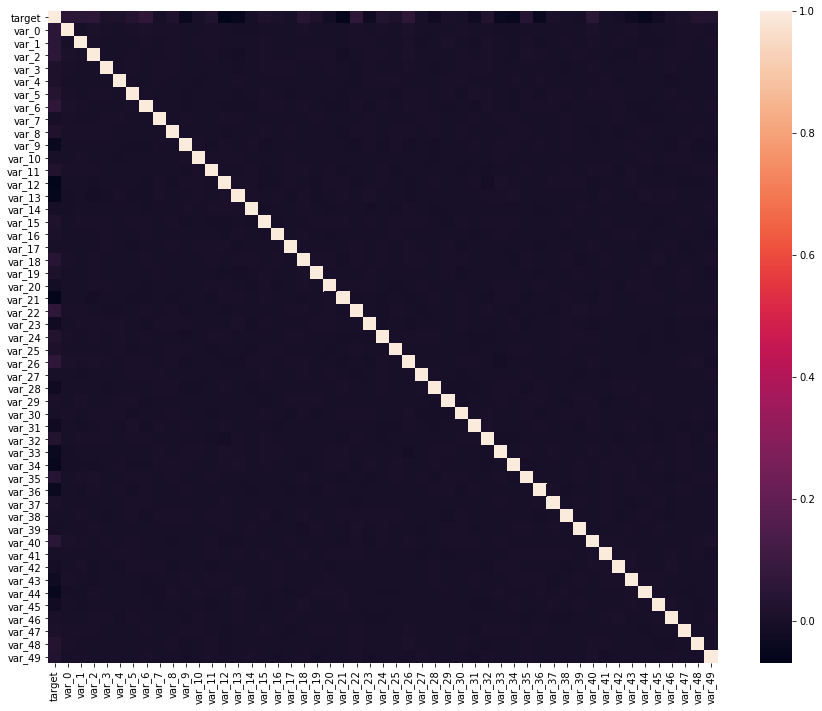

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,12))
sns.heatmap(train.iloc[:,:51].corr())

In [21]:
#doesn't look like there is any correlation between any variables after checking randomly
target_corr = train.corr()['target']
target_corr

target     1.000000
var_0      0.052390
var_1      0.050343
var_2      0.055870
var_3      0.011055
var_4      0.010915
var_5      0.030979
var_6      0.066731
var_7     -0.003025
var_8      0.019584
var_9     -0.042805
var_10    -0.002213
var_11     0.022993
var_12    -0.069489
var_13    -0.055156
var_14    -0.006332
var_15     0.017283
var_16     0.008117
var_17     0.000864
var_18     0.043479
var_19     0.011291
var_20    -0.018329
var_21    -0.058483
var_22     0.060558
var_23    -0.025473
var_24     0.028477
var_25     0.013328
var_26     0.062422
var_27    -0.000582
var_28    -0.023942
var_29     0.004682
var_30     0.000638
var_31    -0.025619
var_32     0.030513
var_33    -0.044334
var_34    -0.052692
var_35     0.036567
var_36    -0.038397
var_37     0.007685
var_38     0.000970
var_39    -0.004090
var_40     0.049530
var_41    -0.001298
var_42    -0.008365
var_43    -0.028557
var_44    -0.049039
var_45    -0.020065
var_46     0.005690
var_47     0.008983
var_48     0.032334


Text(0.5, 1.0, "Each variable's correlation with target")

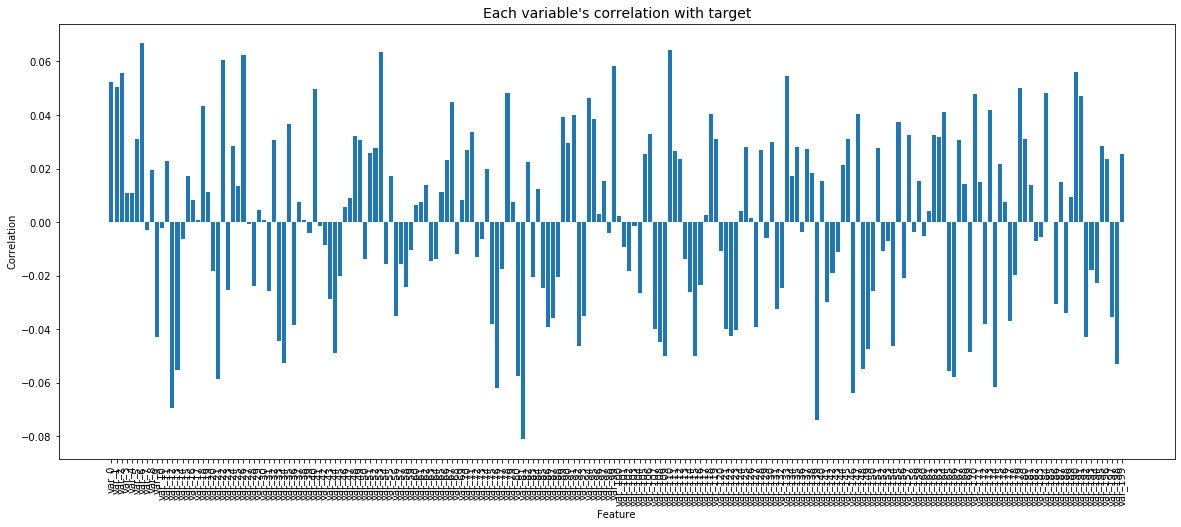

In [520]:
x = list(target_corr.index[1:])
plt.figure(figsize=(20,8))
plt.bar(x=x,height=target_corr[1:])
plt.xlabel('Feature')
plt.ylabel('Correlation')
plt.xticks(rotation=90)
plt.title("Each variable's correlation with target",fontsize=14)


([], <a list of 0 Text yticklabel objects>)

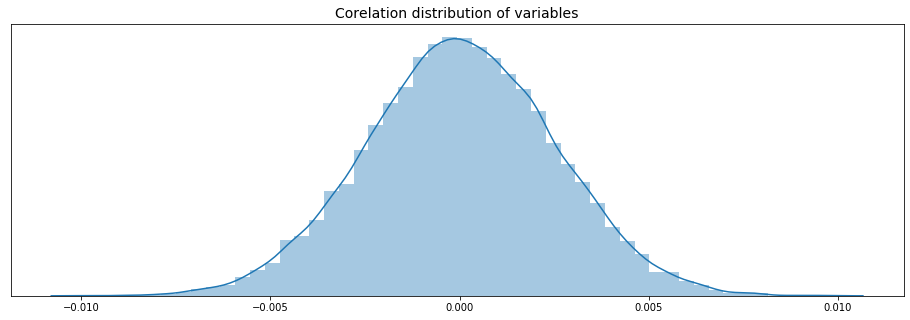

In [525]:
#corelation between variables
train_corr = train.iloc[:,:-1].corr()
train_corr = train_corr.values.flatten()
train_corr = train_corr[train_corr!=1]

plt.figure(figsize=(16,5))
plt.title('Corelation distribution of variables',fontsize=14)
sns.distplot(train_corr)
plt.yticks(ticks=[])

In [523]:
train.columns

Index(['var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7',
       'var_8', 'var_9',
       ...
       'var_191', 'var_192', 'var_193', 'var_194', 'var_195', 'var_196',
       'var_197', 'var_198', 'var_199', 'target'],
      dtype='object', length=201)

    From the bar plot:
    Maximum correlation to the target is also less than 10%. It is very difficult to tell which variable could help predictions
    
    From the distribution plot:
    The is a clear peak at 0 and falling very rapidly going away from 0, hence it is safe to say there is very little corelation between variables(alomost 0)

#### Random Forest
    Let's build a random forest to understand variable importances. We will be using stratified sampling. 
    why stratified sampling? what other sampling methods can we use in this problem?

    We used stratified sampling to maintain the ratio of classes in our train, validation and test splits.

In [134]:
def apply_stratifiedshufflesplit(train,test_size = 0.2):
    sss = StratifiedShuffleSplit(n_splits=1,test_size=test_size)
    X = train[train.columns.drop('target')]
    Y = train['target']
    for train_ind, test_ind in sss.split(X,Y):
        x_train, x_test = X.loc[train_ind],X.loc[test_ind]
        y_train, y_test = Y[train_ind],Y[test_ind]
        
    return x_train, x_test, y_train, y_test


rfc = RandomForestClassifier()

param_distribution = {'criterion':['gini','entropy'],
                     'max_depth':[3,8,15],
                     'n_estimators':[5,10,13]}

rand = RandomizedSearchCV(rfc,cv=3,param_distributions=param_distribution,scoring='accuracy')
rand.fit(x_train,y_train)


print(rand.best_score_, rand.best_params_)
print(rand.cv_results_)



"param_distribution = {'criterion':['gini','entropy'],\n                     'max_depth':[3,8,15],\n                     'n_estimators':[5,10,13]}\n\nrand = RandomizedSearchCV(rfc,cv=3,param_distributions=param_distribution,scoring='accuracy')\nrand.fit(x_train,y_train)\n\n\nprint(rand.best_score_, rand.best_params_)\nprint(rand.cv_results_)"

In [28]:
rfc.fit(x_train,y_train)
pred = rfc.predict(x_test)
print(accuracy_score(y_test,pred))
print(classification_report(y_test,pred))

/Users/gurumanikanta/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8994
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     35980
           1       0.48      0.01      0.02      4020

    accuracy                           0.90     40000
   macro avg       0.69      0.50      0.48     40000
weighted avg       0.86      0.90      0.85     40000



In [29]:
prob_pred = rfc.predict_proba(x_test)

AUC:  0.504916081073233


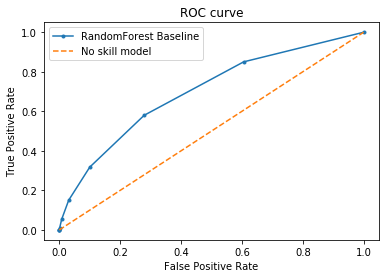

In [30]:
rfc_fpr, rfc_tpr, _ = roc_curve(y_test,prob_pred[:,1])
ns_fpr, ns_tpr, _ = roc_curve(y_test,np.zeros(len(y_test)))


plt.title('ROC curve')
plt.plot(rfc_fpr,rfc_tpr,label='RandomForest Baseline',marker='.')
plt.plot(ns_fpr,ns_tpr,label='No skill model',linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
print('AUC: ',roc_auc_score(y_test,pred))

AUC:  0.23470526465408778


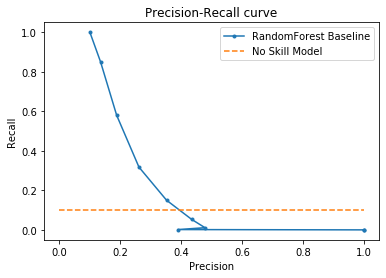

In [31]:
rfc_prec, rfc_recall, _ = precision_recall_curve(y_test,prob_pred[:,1])
no_skill = len(y_test[y_test==1]) / len(y_test)

plt.title('Precision-Recall curve')
plt.plot(rfc_prec,rfc_recall,label='RandomForest Baseline',marker='.')
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill Model')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend()
print('AUC: ',auc(rfc_recall,rfc_prec))

    We got good auc with the roc curve, why use a precison-recall curve again? Isn't it just degrading our model performance? why? why not?

    Conclusions:
    
    1. The model is very simple, in that it predicts most of the test cases to be 0 because of the domination in training data and hence fails to preform well
    2. The ROC curve had given a pretty optimistic view of the model. That happened because in building the ROC curve we take into account the effect of the numerous True Negatives that our model predicted.
    TN inc => fpr decrease, thats the initial case but with increasing tpr the TN reduced increasing the fpr
    3. In Precision-Recall curve, any over optimism portrayed because of precision(predicting TNs correctly) is handled by the recall that concentrates on TP
    
    For this reason it is preferred to use a Precision-Recall curve instead of ROC when the data is not balanced. However, we will keep using ROC as our preferred metric for this analysis but will try to bridge the gap between ROC and Precision-Recall curves
*One important reason to perform this RandomForestClassifier is, we can use this model to see how the importance of variables look like*

In [32]:
importance = pd.DataFrame()
importance['Features'] = x_train.columns
importance['Importance'] = rfc.feature_importances_

In [33]:
importance.sort_values(by='Importance',ascending=False,inplace=True)
importance.head()

,Features,Importance
81,var_81,0.011561
53,var_53,0.009235
12,var_12,0.009176
110,var_110,0.008911
174,var_174,0.008403


In [34]:
train[['var_81','var_139','var_53','var_12','var_110']].describe()

,var_81,var_139,var_53,var_12,var_110
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,14.718932,7.760215,6.008542,14.023975,5.513268
std,2.299530,7.686263,0.764742,0.190056,3.823169
min,7.586500,-21.274300,3.344900,13.434600,-9.239800
25%,13.214775,2.387575,5.435600,13.894000,2.817475
50%,14.844500,8.066250,6.027800,14.025500,5.394300
75%,16.340799,13.232525,6.542900,14.164200,8.104325
max,23.132401,36.097099,8.231500,14.654500,19.519300


    We can use the average of above summary statistics as features, we will look at how much they contribute to identifying the target. We will see that a little further but first let's check the distributions of the most important variables

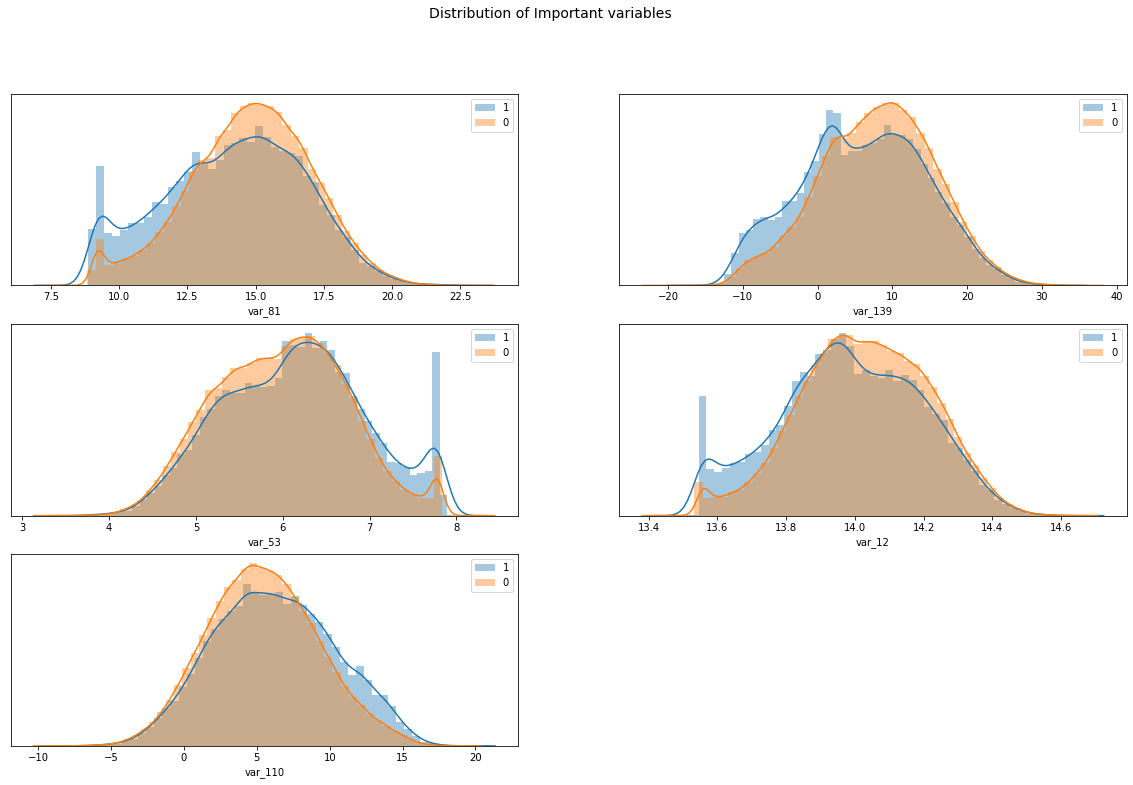

In [511]:
#For ease of use let's define 2 separate dfs for target 1 and 0
'''train_1 = train[train['target']==1]
train_0 = train[train['target']==0]
'''

plt.figure(figsize=(20,12))
plt.tight_layout(h_pad=2)
plt.suptitle('Distribution of Important variables',fontsize=14)
imp_features = ['var_81','var_139','var_53','var_12','var_110']
for val,ind in zip(imp_features,range(len(imp_features))):  
    plt.subplot(3,2,ind+1)
    sns.distplot(train_1[val],label='1')
    sns.distplot(train_0[val],label='0')
    plt.legend()
    plt.yticks(ticks=[])

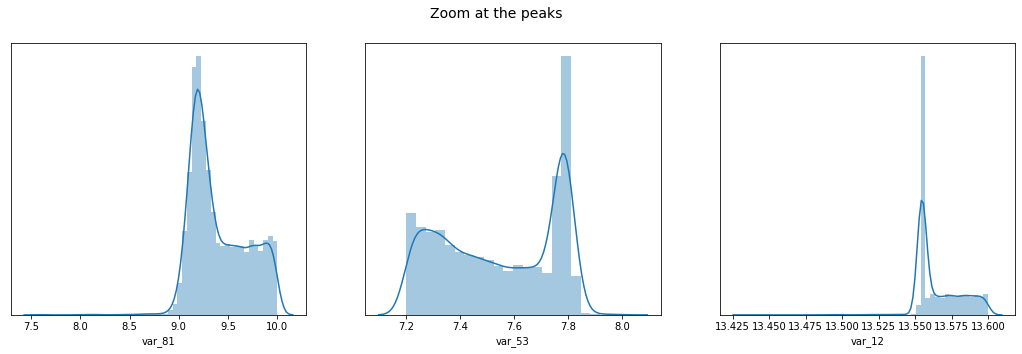

In [512]:
#certain peaks around 10, 7.8, 15.5 for var_81, var_53 and var_12 respectively
fig,ax = plt.subplots(1,3,figsize=(18,5))
ax = ax.flatten()
plt.suptitle('Zoom at the peaks',fontsize=14)
sns.distplot(train[train['var_81']<10]['var_81'],ax = ax[0])
sns.distplot(train[(train['var_53']<8) & (train['var_53']>7.2)]['var_53'],ax = ax[1])
sns.distplot(train[train['var_12']<13.6]['var_12'],ax = ax[2])
for a in ax:
    a.set_yticks([])

In [50]:
print('var_81 \n',pd.value_counts(train[(train['var_81']>9) & (train['var_81']<9.4)]['target']))
print('var_53 \n',pd.value_counts(train[(train['var_53']>7.7) & (train['var_53']<7.88)]['target']))
print('var_12 \n',pd.value_counts(train[(train['var_12']>13.5) & (train['var_12']<13.565)]['target']))

var_81 
 0    3136
1     933
Name: target, dtype: int64
var_53 
 0    3294
1     930
Name: target, dtype: int64
var_12 
 0    1912
1     583
Name: target, dtype: int64


    At first glance the peaks seemed like a good place for exploration but look at the value counts above, the ratio of 0 and 1 is almost same as the original ratio of the population. This proves there is nothing different about these peaks from the rest of the data

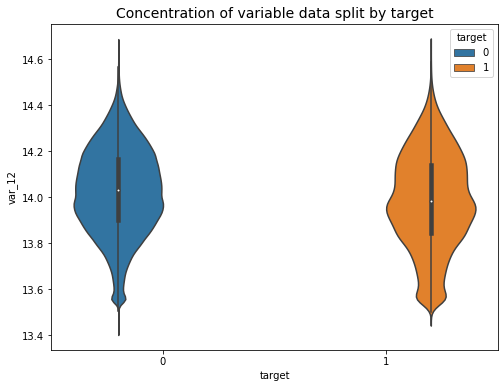

In [513]:
plt.figure(figsize=(8,6))
plt.title('Concentration of variable data split by target',fontsize=14)
sns.violinplot(data = train, x='target',y='var_12',hue='target')

    The violin plot also proves the previous finding, irrespective of the target value most of the concentration of a variable lies around the same value. It is very difficult to differentiate data since this would result in overlap as seen in the distribution plots

In [79]:
#unq_81 = np.sort(train['var_81'].unique())
unq_81[:15]

array([7.58650017, 7.59380007, 7.99720001, 8.01889992, 8.0248003 ,
       8.1335001 , 8.13990021, 8.15180016, 8.29080009, 8.4435997 ,
       8.4442997 , 8.45890045, 8.56470013, 8.57229996, 8.59070015])

    If the data were scaled by a standard scaling method, there would be clues when the unique values are sorted. Some clues might be:
    - Difference between pairs of any 2 concecutive numbers is same
    - mean of distribution is almost 0, std almost 1(which isn't the case here as seen before)
    
    Sometimes the variables might be standardscaled to make them anonymus but in this case it doesn't even look like it. Though getting the original values might not help much in understanding the variable meaning, working directly with original data is less painstaking than with anonymus scaled data

****Lets look at some statistics both row and column wise****

### Splitting Validation set from training

    We have train and test sets seperately, is it really necessary to have a validation set? By this time you would have performed these steps already, if you hadn't we encourage you to ponder about why a validation set is helpful.

In [145]:
#before going any further I will make a validation set out of the training data and work only with the train part
x, x_test, y, y_test = apply_stratifiedshufflesplit(train,0.1)
train_data = x.join(y)
test_data = x_test.join(y_test)

train_data.reset_index(drop=True,inplace=True)
x_train, x_valid, y_train, y_valid = apply_stratifiedshufflesplit(train_data,0.1)
train_data = x_train.join(y_train)
valid_data = x_valid.join(y_valid)

In [ ]:
columns = train_data.columns.drop('target')
train_data_1 = train_data[train_data['target']==1]
train_data_0 = train_data[train_data['target']==0]


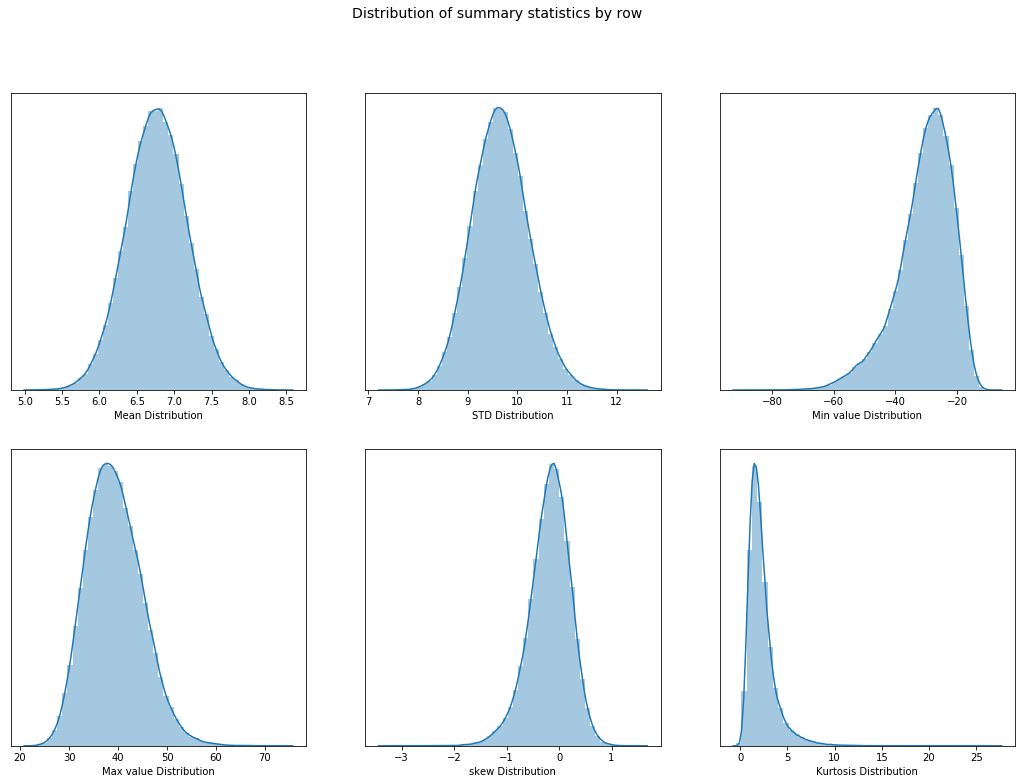

In [483]:
fig, ax = plt.subplots(2,3,figsize=(18,12))
plt.suptitle('Distribution of summary statistics by row',fontsize=14)

ax = ax.flatten()
sns.distplot(train_data[columns].mean(axis=1),ax=ax[0],axlabel='Mean Distribution',)
sns.distplot(train_data[columns].std(axis=1),ax=ax[1],axlabel='STD Distribution')
sns.distplot(train_data[columns].min(axis=1),ax=ax[2],axlabel='Min value Distribution')
sns.distplot(train_data[columns].max(axis=1),ax=ax[3],axlabel='Max value Distribution')
sns.distplot(train_data[columns].skew(axis=1),ax=ax[4],axlabel='skew Distribution')
sns.distplot(train_data[columns].kurtosis(axis=1),ax=ax[5],axlabel='Kurtosis Distribution')

for a in ax:
    a.set_yticks([])

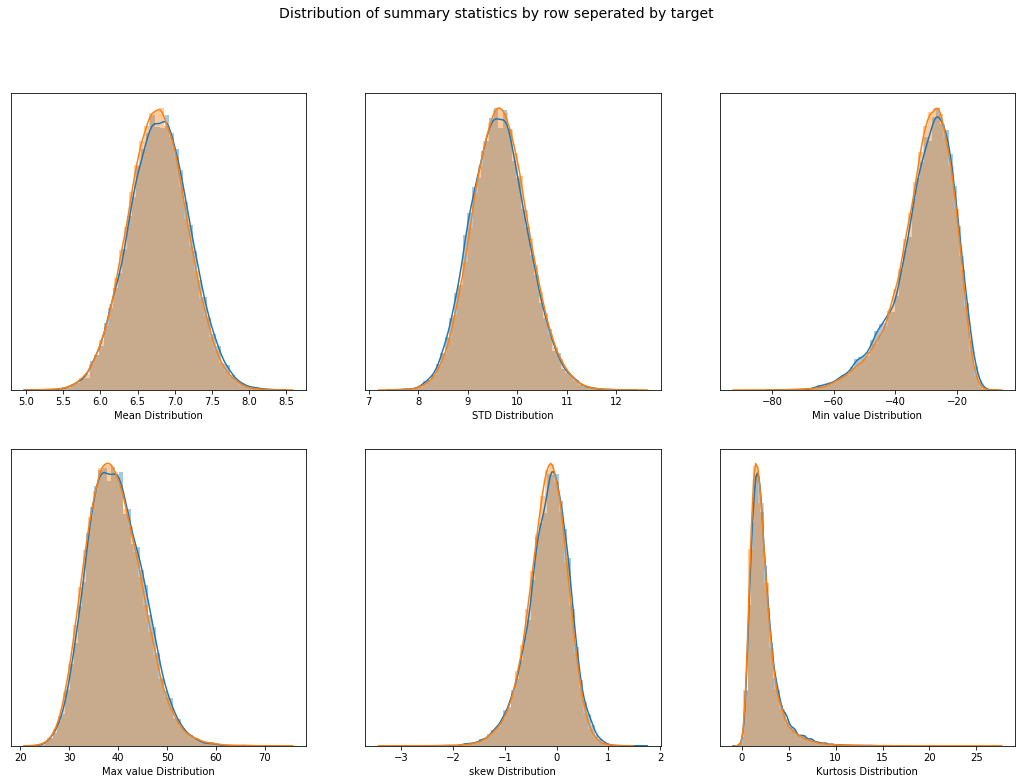

In [484]:
fig, ax = plt.subplots(2,3,figsize=(18,12))
plt.suptitle('Distribution of summary statistics by row seperated by target',fontsize=14)

ax = ax.flatten()
sns.distplot(train_data_1[columns].mean(axis=1),ax=ax[0],axlabel='Mean Distribution')
sns.distplot(train_data_0[columns].mean(axis=1),ax=ax[0])
sns.distplot(train_data_1[columns].std(axis=1),ax=ax[1],axlabel='STD Distribution')
sns.distplot(train_data_0[columns].std(axis=1),ax=ax[1])
sns.distplot(train_data_1[columns].min(axis=1),ax=ax[2],axlabel='Min value Distribution')
sns.distplot(train_data_0[columns].min(axis=1),ax=ax[2])
sns.distplot(train_data_1[columns].max(axis=1),ax=ax[3],axlabel='Max value Distribution')
sns.distplot(train_data_0[columns].max(axis=1),ax=ax[3])
sns.distplot(train_data_1[columns].skew(axis=1),ax=ax[4],axlabel='skew Distribution')
sns.distplot(train_data_0[columns].skew(axis=1),ax=ax[4])
sns.distplot(train_data_1[columns].kurtosis(axis=1),ax=ax[5],axlabel='Kurtosis Distribution')
sns.distplot(train_data_0[columns].kurtosis(axis=1),ax=ax[5])

for a in ax:
    a.set_yticks([])

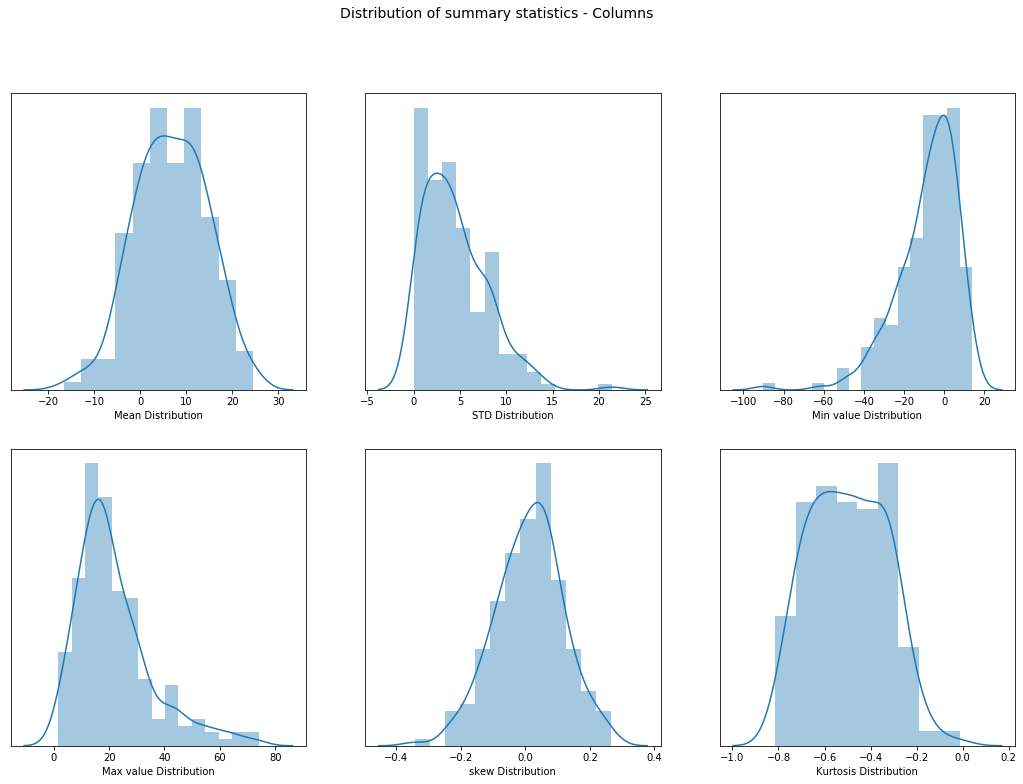

In [485]:
fig, ax = plt.subplots(2,3,figsize=(18,12))
plt.suptitle('Distribution of summary statistics - Columns',fontsize=14)

ax = ax.flatten()
sns.distplot(train_data[columns].mean(axis=0),ax=ax[0],axlabel='Mean Distribution')
sns.distplot(train_data[columns].std(axis=0),ax=ax[1],axlabel='STD Distribution')
sns.distplot(train_data[columns].min(axis=0),ax=ax[2],axlabel='Min value Distribution')
sns.distplot(train_data[columns].max(axis=0),ax=ax[3],axlabel='Max value Distribution')
sns.distplot(train_data[columns].skew(axis=0),ax=ax[4],axlabel='skew Distribution')
sns.distplot(train_data[columns].kurtosis(axis=0),ax=ax[5],axlabel='Kurtosis Distribution')

for a in ax:
    a.set_yticks([])

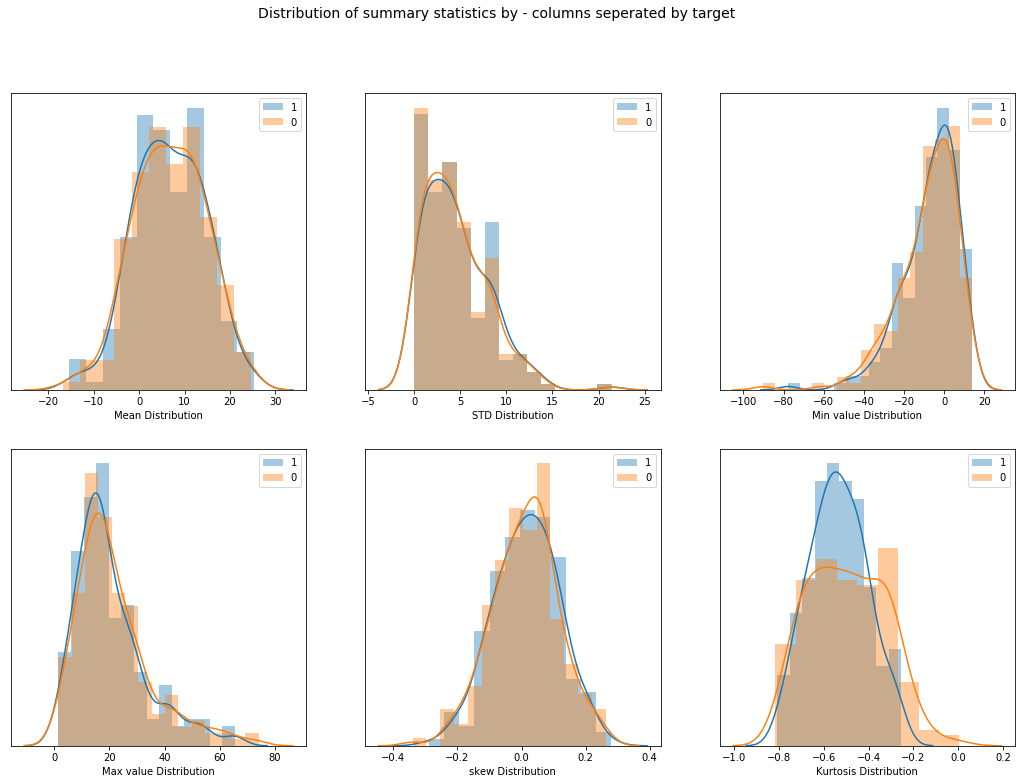

In [486]:
fig, ax = plt.subplots(2,3,figsize=(18,12))
plt.suptitle('Distribution of summary statistics by - columns seperated by target',fontsize=14)

ax = ax.flatten()
sns.distplot(train_data_1[columns].mean(axis=0),ax=ax[0],axlabel='Mean Distribution',label='1')
sns.distplot(train_data_0[columns].mean(axis=0),ax=ax[0],label='0')
ax[0].legend()
sns.distplot(train_data_1[columns].std(axis=0),ax=ax[1],axlabel='STD Distribution',label='1')
sns.distplot(train_data_0[columns].std(axis=0),ax=ax[1],label='0')
ax[1].legend()
sns.distplot(train_data_1[columns].min(axis=0),ax=ax[2],axlabel='Min value Distribution',label='1')
sns.distplot(train_data_0[columns].min(axis=0),ax=ax[2],label='0')
ax[2].legend()
sns.distplot(train_data_1[columns].max(axis=0),ax=ax[3],axlabel='Max value Distribution',label='1')
sns.distplot(train_data_0[columns].max(axis=0),ax=ax[3],label='0')
ax[3].legend()
sns.distplot(train_data_1[columns].skew(axis=0),ax=ax[4],axlabel='skew Distribution',label='1')
sns.distplot(train_data_0[columns].skew(axis=0),ax=ax[4],label='0')
ax[4].legend()
sns.distplot(train_data_1[columns].kurtosis(axis=0),ax=ax[5],axlabel='Kurtosis Distribution',label='1')
sns.distplot(train_data_0[columns].kurtosis(axis=0),ax=ax[5],label='0')
ax[5].legend()

for a in ax:
    a.set_yticks([])

    We can clearly notice that most distributions of summary statistics are overlapping for target 1 and 0 rendering them not very useful for prediction. However, we will use them in our model to see if it could capture the minor differences we observe

## Feature Engineering
    In any ML problem this step is crucial in that it reveals the information hiding underneath. In this particular scenario Feature Engineering becomes pivotal since there is no basis to say if a feature is actually contributing to target. 

In [171]:
#Let's start small: adding up the values of important features
train_data['var_81+var_53'] = train_data['var_81'] + train_data['var_53']
train_data['var_81+var_12'] = train_data['var_81'] + train_data['var_12']
train_data['var_81+var_53+var_12'] = train_data['var_81'] + train_data['var_53'] + train_data['var_12']

valid_data['var_81+var_53'] = valid_data['var_81'] + valid_data['var_53']
valid_data['var_81+var_12'] = valid_data['var_81'] + valid_data['var_12']
valid_data['var_81+var_53+var_12'] = valid_data['var_81'] + valid_data['var_53'] + valid_data['var_12']

In [172]:
#Running the rfc again
rfc = RandomForestClassifier()
rfc.fit(x_train,y_train)
pred = rfc.predict(x_valid)

print(classification_report(y_valid,pred))

/Users/gurumanikanta/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95     16192
           1       0.59      0.02      0.03      1808

    accuracy                           0.90     18000
   macro avg       0.75      0.51      0.49     18000
weighted avg       0.87      0.90      0.86     18000



In [174]:
roc_auc_score(y_valid,pred)
#no improvement, so let's remove these new columns

0.5074023225716184

In [228]:
train_data.drop(labels=['var_81+var_53','var_81+var_12','var_81+var_53+var_12'],inplace=True,axis=1)
valid_data.drop(labels=['var_81+var_53','var_81+var_12','var_81+var_53+var_12'],inplace=True,axis=1)

In [178]:
#Let's add the new fetures from summary statistics
#columns is the list of columns excluding the target
summary_stats = ['mean','std','min','max','skew','kurtosis']
def get_summary_stats(df):
    for stat in summary_stats:
        df[stat] = eval('df[columns].'+stat+'(axis=1)')


In [179]:
get_summary_stats(train_data)
get_summary_stats(valid_data)

In [180]:
train_data.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,...,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,target,var_81+var_53,var_81+var_12,var_81+var_53+var_12,mean,std,min,max,skew,kurtosis
134138,14.3282,-7.5382,8.5238,7.5148,9.7073,2.8474,5.7129,18.076599,2.4910,7.7844,-6.4314,-5.5834,13.9254,8.7488,9.5032,14.1051,11.1203,-14.3308,18.372400,6.778500,8.649400,19.333900,5.2503,3.8591,4.9367,13.8561,-6.3845,0.3338,3.9756,4.7452,-2.1907,10.6154,0.8384,15.515200,11.0141,1.9442,4.4600,2.9296,9.050500,6.5173,-16.159800,7.6757,11.4257,11.7294,10.5338,7.253100,12.3463,-14.4635,18.354601,18.741699,13.5782,23.044300,-0.7746,6.7092,-10.1595,11.945200,19.387699,6.8411,5.3159,8.4072,11.0720,-14.0159,2.6562,1.4562,6.6795,-0.1908,4.0048,7.539300,5.0286,-4.3443,11.220800,0.4854,4.0809,12.0801,0.833900,21.276400,-0.3064,18.504499,7.5938,14.948700,14.3260,12.2601,17.9818,8.0055,-6.0278,19.7299,1.237000,8.5797,10.0657,4.8089,-25.851700,6.8062,18.697300,9.8876,13.2877,0.3418,2.765900,27.204800,2.2241,-4.8550,...,2.0316,6.2957,3.4194,10.3793,2.7214,4.7825,4.6382,13.290300,-19.9048,6.8757,3.592800,9.5683,-7.9679,9.3886,3.5093,12.3552,11.6968,3.3267,-2.2366,10.1909,10.9160,0.8589,8.1308,7.4361,1.2600,-9.7912,22.445999,15.0832,3.1902,8.5591,0.0177,-3.2359,11.024300,15.2654,10.4744,2.0050,7.1858,-5.4642,4.1408,-1.121900,16.903700,13.7820,8.0733,16.380899,16.868799,2.6722,12.7660,-5.1751,25.354799,8.4745,40.628201,5.5906,4.6510,4.166800,2.5702,16.286100,3.7129,13.7805,1.5662,5.9585,-4.1917,2.9017,43.586601,5.3307,21.910900,8.7670,9.1284,11.2634,-0.6420,1.0233,0.2018,8.9617,18.1439,8.1345,23.7514,-12.5629,6.9032,-24.371099,21.719101,0.8389,5.6588,13.0300,3.6952,2.4496,23.852699,-2.3851,-0.1943,9.7409,18.454100,-12.9396,0,18.969299,26.185501,32.894699,7.022247,9.849718,-25.851700,43.586601,-0.018447,1.962420
172820,7.0201,1.5604,9.9750,7.8781,10.3947,-14.7461,5.7713,16.889400,-3.6768,5.7345,6.6759,-11.4318,14.0848,11.6248,10.0589,14.8314,9.8471,-4.2125,20.350201,9.547100,19.548901,21.459000,4.1742,2.8799,6.9813,13.6545,-4.2876,0.9373,6.1874,5.7095,-7.0049,8.6416,-1.0925,15.337100,10.6804,-2.6731,2.1075,7.9388,16.072599,3.3532,13.096100,9.3554,10.9058,11.0214,6.7810,-22.099899,12.1956,-5.6015,20.807800,13.558000,13.0517,12.412400,-3.9036,6.2010,5.9667,20.964100,13.322400,5.7769,2.9890,8.8042,10.8525,-1.6811,2.3380,3.5750,7.3490,2.5217,4.7461,8.826900,5.0144,-7.4365,17.464600,0.9813,-3.7357,11.0814,17.249599,23.017000,12.8809,12.056100,7.3991,13.489200,11.4897,10.6050,-11.4451,9.3518,-6.9974,14.2471,-1.989200,15.6340,12.1924,1.1923,-20.263599,7.0842,14.386400,10.0187,11.4952,-0.5557,19.323999,17.781401,2.2643,0.2663,...,-1.8582,7.5748,0.0145,7.2885,2.7448,1.9596,4.2173

In [182]:
rfc = RandomForestClassifier()
rfc.fit(train_data[train_data.columns.drop('target')],train_data['target'])
pred = rfc.predict(valid_data[valid_data.columns.drop('target')])

print(classification_report(valid_data['target'],pred))
roc_auc_score(valid_data['target'],pred)

/Users/gurumanikanta/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95     16192
           1       0.54      0.02      0.03      1808

    accuracy                           0.90     18000
   macro avg       0.72      0.51      0.49     18000
weighted avg       0.86      0.90      0.86     18000



0.507493594564343

In [492]:
#There is no improvement once again, I am probably keeping the model simpler than necessary
#let's tune it a little
rfc.get_params()
param_distribution = {'max_depth':[3,8,12],
                     'max_features':[150,130]}

gs = GridSearchCV(RandomForestClassifier(bootstrap=True,n_estimators=20),param_grid=param_distribution,n_jobs=-1,scoring='roc_auc',cv=3)
gs.fit(train_data[train_data.columns.drop('target')],train_data['target'])

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=20, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='wa

In [493]:
gs.best_score_

0.7480408604811498

    There surely is some improvement after tuning the model a little. However, we would want more performance than this and faster. For these reasons, lightgbm seems like a good fit

### Lightgbm    
    A gradient boosting algorithm that works on the same principle as GBDT(Gradient Boosting Decision Trees). The reason why this might work better than it's predecisors is the usage of leaf node split rather than levelwise split.

In [465]:
train_d = Dataset(train_data[train_data.columns.drop('target')],label=train_data['target'])
val_d = Dataset(valid_data[valid_data.columns.drop('target')],label=valid_data['target'],reference=train_d)

In [236]:
start = time.time()
params = {'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 5}

lgb = lightgbm.train(params= params,
                     train_set= train_d,
                     valid_sets= val_d,
                     early_stopping_rounds=10)

end = time.time()

print('Time taken in sec: ',end-start)

[1]	valid_0's auc: 0.649032
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.699556
[3]	valid_0's auc: 0.718791
[4]	valid_0's auc: 0.732311
[5]	valid_0's auc: 0.737605
[6]	valid_0's auc: 0.746201
[7]	valid_0's auc: 0.749859
[8]	valid_0's auc: 0.754005
[9]	valid_0's auc: 0.757174
[10]	valid_0's auc: 0.763794
[11]	valid_0's auc: 0.769575
[12]	valid_0's auc: 0.771754
[13]	valid_0's auc: 0.774797
[14]	valid_0's auc: 0.776307
[15]	valid_0's auc: 0.778087
[16]	valid_0's auc: 0.779894
[17]	valid_0's auc: 0.7815
[18]	valid_0's auc: 0.783018
[19]	valid_0's auc: 0.78478
[20]	valid_0's auc: 0.784611
[21]	valid_0's auc: 0.786212
[22]	valid_0's auc: 0.788431
[23]	valid_0's auc: 0.790363
[24]	valid_0's auc: 0.792826
[25]	valid_0's auc: 0.794469
[26]	valid_0's auc: 0.796515
[27]	valid_0's auc: 0.798099
[28]	valid_0's auc: 0.799249
[29]	valid_0's auc: 0.799468
[30]	valid_0's auc: 0.801469
[31]	valid_0's auc: 0.803308
[32]	valid_0's auc: 0.80374
[33]	valid_0's auc: 0.80

In [237]:
test_pred = lgb.predict(test_data[test_data.columns.drop('target')])
roc_auc_score(test_data['target'],test_pred)

0.8498573772838909

AUC:  0.46550263461699537


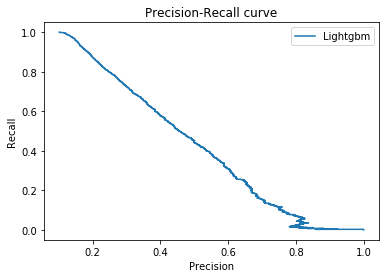

In [238]:
prec, recall, _ = precision_recall_curve(test_data['target'],test_pred)
plt.title('Precision-Recall curve')
plt.plot(prec,recall,label='Lightgbm')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend()
print('AUC: ',auc(recall,prec))

    Clearly there is an improvement in the model performance i.e, light gbm is able to capture differences in the data better than a RandomForest. You can notice the initial roc_auc_score of lightgbm even without using iterations was 64.9% which is almost as good as our best RandomForest. By the end of 100 iterations lightgbm was able to get to 84.6% auc. Let's increase the number of iterations to 1000 with early stopping(if the score doesn't improve for given number of rounds, stop running) at 20 rounds

In [466]:
start = time.time()
params = {'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 5}

lgb = lightgbm.train(params= params,
                     train_set= train_d,
                     valid_sets= val_d,
                     early_stopping_rounds=20,
                     num_boost_round=1000)

end = time.time()
print('Time taken in sec: ',end-start)

[1]	valid_0's auc: 0.649032
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.68578
[3]	valid_0's auc: 0.717828
[4]	valid_0's auc: 0.730228
[5]	valid_0's auc: 0.740613
[6]	valid_0's auc: 0.748975
[7]	valid_0's auc: 0.758181
[8]	valid_0's auc: 0.761282
[9]	valid_0's auc: 0.764758
[10]	valid_0's auc: 0.771221
[11]	valid_0's auc: 0.774309
[12]	valid_0's auc: 0.775759
[13]	valid_0's auc: 0.779129
[14]	valid_0's auc: 0.781999
[15]	valid_0's auc: 0.782834
[16]	valid_0's auc: 0.785025
[17]	valid_0's auc: 0.786217
[18]	valid_0's auc: 0.788096
[19]	valid_0's auc: 0.789727
[20]	valid_0's auc: 0.79163
[21]	valid_0's auc: 0.793921
[22]	valid_0's auc: 0.795295
[23]	valid_0's auc: 0.797283
[24]	valid_0's auc: 0.798986
[25]	valid_0's auc: 0.800348
[26]	valid_0's auc: 0.801294
[27]	valid_0's auc: 0.803158
[28]	valid_0's auc: 0.804276
[29]	valid_0's auc: 0.805289
[30]	valid_0's auc: 0.806664
[31]	valid_0's auc: 0.80718
[32]	valid_0's auc: 0.807562
[33]	valid_0's auc: 0.8

[278]	valid_0's auc: 0.875675
[279]	valid_0's auc: 0.875774
[280]	valid_0's auc: 0.875913
[281]	valid_0's auc: 0.875992
[282]	valid_0's auc: 0.876166
[283]	valid_0's auc: 0.876235
[284]	valid_0's auc: 0.876331
[285]	valid_0's auc: 0.876387
[286]	valid_0's auc: 0.876388
[287]	valid_0's auc: 0.876495
[288]	valid_0's auc: 0.876495
[289]	valid_0's auc: 0.876565
[290]	valid_0's auc: 0.876614
[291]	valid_0's auc: 0.876686
[292]	valid_0's auc: 0.876656
[293]	valid_0's auc: 0.876833
[294]	valid_0's auc: 0.876875
[295]	valid_0's auc: 0.877042
[296]	valid_0's auc: 0.877057
[297]	valid_0's auc: 0.877062
[298]	valid_0's auc: 0.877166
[299]	valid_0's auc: 0.877281
[300]	valid_0's auc: 0.877355
[301]	valid_0's auc: 0.877499
[302]	valid_0's auc: 0.87752
[303]	valid_0's auc: 0.877561
[304]	valid_0's auc: 0.877598
[305]	valid_0's auc: 0.877735
[306]	valid_0's auc: 0.877752
[307]	valid_0's auc: 0.877733
[308]	valid_0's auc: 0.877728
[309]	valid_0's auc: 0.87783
[310]	valid_0's auc: 0.877903
[311]	valid_

In [467]:
test_pred = lgb.predict(test_data[test_data.columns.drop('target')])
roc_auc_score(test_data['target'],test_pred)

0.8875632716219342

AUC:  0.5783817807996283


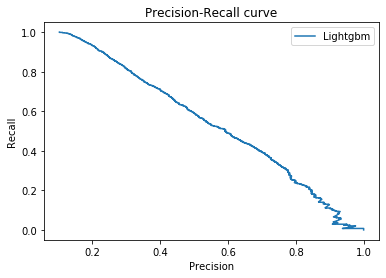

In [468]:
prec, recall, _ = precision_recall_curve(test_data['target'],test_pred)
plt.title('Precision-Recall curve')
plt.plot(prec,recall,label='Lightgbm')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend()
print('AUC: ',auc(recall,prec))

    Now our model stopped after 470 rounds at 88.3%. Clearly, this score is far better than any other model we have built so far. It's not just the score that has improved with the usage of lightgbm, the speed at which it ran was far better than our previous RandomForest models, for 100 iteratins - 12.04 sec and for 533 iterations - 67 sec while the same for RandomForest models at lesser estimators, depth spanned several minutes. However, as we have seen earlier the roc_auc is not a prefect measure since it is inclined to give better results due to the effect of TNs and hence we will also look at Precision-Recall curves
    
    We can further improve our model by carefully increasing the number of iterations and early_stopping_rounds to avoid overfitting. We can also engineer more features for better understanding of data
    
    I'm going to try the lgb once more with 2000 iterations with early stopping at 30

In [400]:
start = time.time()
params = {'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 5}

lgb = lightgbm.train(params= params,
                     train_set= train_d,
                     valid_sets= val_d,
                     early_stopping_rounds=30,
                     num_boost_round=2000)

end = time.time()
print('Time taken in sec: ',end-start)

[1]	valid_0's auc: 0.649032
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.68578
[3]	valid_0's auc: 0.717828
[4]	valid_0's auc: 0.730228
[5]	valid_0's auc: 0.740613
[6]	valid_0's auc: 0.748975
[7]	valid_0's auc: 0.758181
[8]	valid_0's auc: 0.761282
[9]	valid_0's auc: 0.764758
[10]	valid_0's auc: 0.771221
[11]	valid_0's auc: 0.774309
[12]	valid_0's auc: 0.775759
[13]	valid_0's auc: 0.779129
[14]	valid_0's auc: 0.781999
[15]	valid_0's auc: 0.782834
[16]	valid_0's auc: 0.785025
[17]	valid_0's auc: 0.786217
[18]	valid_0's auc: 0.788096
[19]	valid_0's auc: 0.789727
[20]	valid_0's auc: 0.79163
[21]	valid_0's auc: 0.793921
[22]	valid_0's auc: 0.795295
[23]	valid_0's auc: 0.797283
[24]	valid_0's auc: 0.798986
[25]	valid_0's auc: 0.800348
[26]	valid_0's auc: 0.801294
[27]	valid_0's auc: 0.803158
[28]	valid_0's auc: 0.804276
[29]	valid_0's auc: 0.805289
[30]	valid_0's auc: 0.806664
[31]	valid_0's auc: 0.80718
[32]	valid_0's auc: 0.807562
[33]	valid_0's auc: 0.8

[279]	valid_0's auc: 0.875774
[280]	valid_0's auc: 0.875913
[281]	valid_0's auc: 0.875992
[282]	valid_0's auc: 0.876166
[283]	valid_0's auc: 0.876235
[284]	valid_0's auc: 0.876331
[285]	valid_0's auc: 0.876387
[286]	valid_0's auc: 0.876388
[287]	valid_0's auc: 0.876495
[288]	valid_0's auc: 0.876495
[289]	valid_0's auc: 0.876565
[290]	valid_0's auc: 0.876614
[291]	valid_0's auc: 0.876686
[292]	valid_0's auc: 0.876656
[293]	valid_0's auc: 0.876833
[294]	valid_0's auc: 0.876875
[295]	valid_0's auc: 0.877042
[296]	valid_0's auc: 0.877057
[297]	valid_0's auc: 0.877062
[298]	valid_0's auc: 0.877166
[299]	valid_0's auc: 0.877281
[300]	valid_0's auc: 0.877355
[301]	valid_0's auc: 0.877499
[302]	valid_0's auc: 0.87752
[303]	valid_0's auc: 0.877561
[304]	valid_0's auc: 0.877598
[305]	valid_0's auc: 0.877735
[306]	valid_0's auc: 0.877752
[307]	valid_0's auc: 0.877733
[308]	valid_0's auc: 0.877728
[309]	valid_0's auc: 0.87783
[310]	valid_0's auc: 0.877903
[311]	valid_0's auc: 0.877952
[312]	valid_

Time taken in sec:  70.72452878952026


In [401]:
test_pred = lgb.predict(test_data[test_data.columns.drop('target')])
roc_auc_score(test_data['target'],test_pred)

0.8878964801374465

AUC:  0.5788044146075851


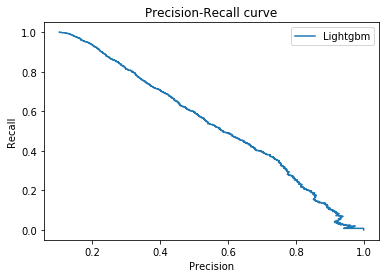

In [402]:
prec, recall, _ = precision_recall_curve(test_data['target'],test_pred)
plt.title('Precision-Recall curve')
plt.plot(prec,recall,label='Lightgbm')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend()
print('AUC: ',auc(recall,prec))

    There is very small improvement in the performance, approximately 11%. We would like to bridge the gap between ROC and Precision-Recall curves, hence capturing most of the information
    
    In that spirit, I am going to create features that represent probability of a cell to belong to a transacted class. We can determine this probability by binning each column thereby assigning a probability to that bin based on the target. Let's go! 

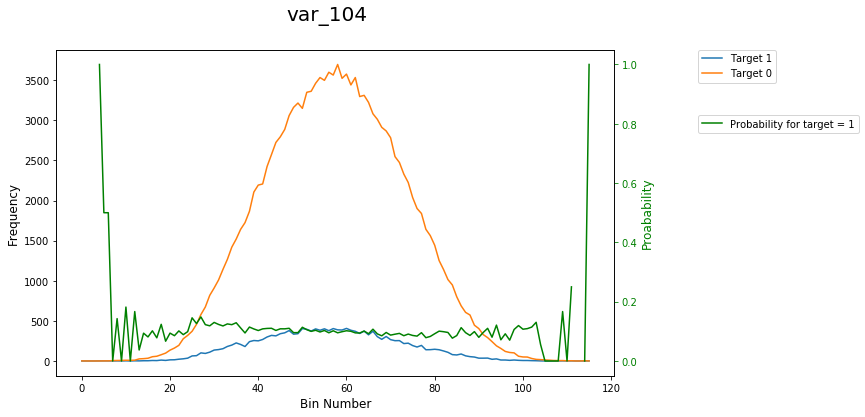

In [478]:
def draw_plot(var,df_freq1, df_freq0, df_freq):    
    fig, ax = plt.subplots(figsize=(10,6))
    ax2 = ax.twinx()
    plt.suptitle(var,fontsize = 20)
    ax.plot(df_freq1.values,label = 'Target 1')
    ax.plot(df_freq0.values,label = 'Target 0')
    ax.legend(bbox_to_anchor=(1.15, 1), loc=2, borderaxespad=0.)
    ax.set_xlabel('Bin Number',fontsize = 12)
    ax.set_ylabel('Frequency',fontsize = 12)
    ax2.plot(df_freq['target'].values/df_freq['rows'].values,label = 'Probability for target = 1',color='green')
    ax2.legend(bbox_to_anchor=(1.15, 0.8), loc=2, borderaxespad=0.)
    ax2.set_ylabel('Proabability',color='green',fontsize = 12)
    ax2.tick_params(axis='y',colors='green')
    
    
def get_bins_and_plot(var,df):
    
    n = len(df[var])
    iqr = df[var].quantile([.75]).values - df[var].quantile([.25]).values
    bin_size = 2.5*iqr/n**(1/3) #Freedman-Diaconis rule to define the bin size
    bins = int((max(df[var]) - min(df[var]))/bin_size)

    df['bin_'+var] = pd.cut(df[var],bins=bins,labels=range(bins))
    df['rows'] = 1
    
    df_freq = df[['bin_'+var,'target','rows']].groupby(by='bin_'+var).sum()
    df_freq1 = pd.value_counts(df[df['target']==1]['bin_'+var])
    df_freq0 = pd.value_counts(df[df['target']==0]['bin_'+var])
    
    for bin in range(bins):
        if bin not in df_freq1.index:
            df_freq1[bin] = 0
        
        if bin not in df_freq0.index:
            df_freq0[bin] = 0
            
    draw_plot(var,df_freq1.sort_index(),df_freq0.sort_index(),df_freq)
    
    return None


get_bins_and_plot('var_104',train_data.copy(deep=True))
    

    The probability above is the new feature, from the looks of the above graph it looks like the probability of target being 1 is being influenced by the bin. This finding is not just from the current graph, we have randomly looked at multiple variables and almost everytime there is a distinguishable pattern
    
Note: This plot's idea had been extracted from kaggle

In [406]:
def get_probabilities(df):
    var = df[df.columns.drop('target')].columns[0]
    n = len(df[var])
    iqr = df[var].quantile([.75]).values - df[var].quantile([.25]).values
    bin_size = 2.5*iqr/n**(1/3) #Freedman-Diaconis rule to define the bin size
    bins = int((max(df[var]) - min(df[var]))/bin_size)

    df['bin_'+var] = pd.cut(df[var],bins=bins,labels=range(bins))
    df['rows'] = 1
    
    df_freq = df[['bin_'+var,'target','rows']].groupby(by='bin_'+var).sum()
    df_freq['prob'] = df_freq['target']/df_freq['rows']
    prob = lambda val: df_freq.loc[val,'prob']
    df['bin_prob_'+var] = df['bin_'+var].apply(prob)
    
     
    return df[['bin_prob_'+var,'bin_'+var]]

In [373]:
all_probs = pd.DataFrame()
all_probs_valid = pd.DataFrame()
columns = train_data.columns.drop(['target', 'mean', 'std', 'min', 'max','skew', 'kurtosis'])
for col in columns:
    all_probs['prob_'+col] = get_probabilities(train_data[[col,'target']])
    all_probs_valid['prob_'+col] = get_probabilities(valid_data[[col,'target']])

all_probs = all_probs[all_probs.columns.drop('target')].astype('float32')
all_probs['target'] = train_data['target']
all_probs_valid = all_probs_valid[all_probs_valid.columns.drop('target')].astype('float32')
all_probs_valid['target'] = valid_data['target']

In [393]:
#let's define train_d and val_d again
train_d = Dataset(all_probs[all_probs.columns.drop('target')],label=all_probs['target'].values)
val_d = Dataset(all_probs_valid[all_probs_valid.columns.drop('target')],label=all_probs_valid['target'].values,reference=train_d)


In [394]:
start = time.time()
params = {'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 5}

lgb = lightgbm.train(params= params,
                     train_set= train_d,
                     valid_sets= val_d,
                     early_stopping_rounds=30,
                     num_boost_round=2000)

end = time.time()
print('Time taken in sec: ',end-start)

[1]	valid_0's auc: 0.663218
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.713169
[3]	valid_0's auc: 0.72783
[4]	valid_0's auc: 0.744997
[5]	valid_0's auc: 0.752447
[6]	valid_0's auc: 0.760138
[7]	valid_0's auc: 0.770577
[8]	valid_0's auc: 0.778007
[9]	valid_0's auc: 0.785872
[10]	valid_0's auc: 0.792651
[11]	valid_0's auc: 0.795045
[12]	valid_0's auc: 0.80001
[13]	valid_0's auc: 0.804402
[14]	valid_0's auc: 0.808236
[15]	valid_0's auc: 0.811978
[16]	valid_0's auc: 0.814008
[17]	valid_0's auc: 0.816436
[18]	valid_0's auc: 0.819418
[19]	valid_0's auc: 0.821412
[20]	valid_0's auc: 0.823053
[21]	valid_0's auc: 0.824251
[22]	valid_0's auc: 0.826251
[23]	valid_0's auc: 0.828293
[24]	valid_0's auc: 0.829836
[25]	valid_0's auc: 0.831515
[26]	valid_0's auc: 0.833857
[27]	valid_0's auc: 0.836438
[28]	valid_0's auc: 0.838592
[29]	valid_0's auc: 0.838873
[30]	valid_0's auc: 0.839789
[31]	valid_0's auc: 0.840863
[32]	valid_0's auc: 0.842311
[33]	valid_0's auc: 0.

[277]	valid_0's auc: 0.941092
[278]	valid_0's auc: 0.941092
[279]	valid_0's auc: 0.941199
[280]	valid_0's auc: 0.941359
[281]	valid_0's auc: 0.941479
[282]	valid_0's auc: 0.941621
[283]	valid_0's auc: 0.94172
[284]	valid_0's auc: 0.941908
[285]	valid_0's auc: 0.94202
[286]	valid_0's auc: 0.942155
[287]	valid_0's auc: 0.942258
[288]	valid_0's auc: 0.942308
[289]	valid_0's auc: 0.94248
[290]	valid_0's auc: 0.942489
[291]	valid_0's auc: 0.942723
[292]	valid_0's auc: 0.942955
[293]	valid_0's auc: 0.942945
[294]	valid_0's auc: 0.943264
[295]	valid_0's auc: 0.943448
[296]	valid_0's auc: 0.943582
[297]	valid_0's auc: 0.943659
[298]	valid_0's auc: 0.943783
[299]	valid_0's auc: 0.943894
[300]	valid_0's auc: 0.943921
[301]	valid_0's auc: 0.943994
[302]	valid_0's auc: 0.944125
[303]	valid_0's auc: 0.944251
[304]	valid_0's auc: 0.944388
[305]	valid_0's auc: 0.944527
[306]	valid_0's auc: 0.944608
[307]	valid_0's auc: 0.944702
[308]	valid_0's auc: 0.944707
[309]	valid_0's auc: 0.944833
[310]	valid_0

[552]	valid_0's auc: 0.959425
[553]	valid_0's auc: 0.959499
[554]	valid_0's auc: 0.959508
[555]	valid_0's auc: 0.959555
[556]	valid_0's auc: 0.959564
[557]	valid_0's auc: 0.959604
[558]	valid_0's auc: 0.959644
[559]	valid_0's auc: 0.959667
[560]	valid_0's auc: 0.959718
[561]	valid_0's auc: 0.959772
[562]	valid_0's auc: 0.959814
[563]	valid_0's auc: 0.95985
[564]	valid_0's auc: 0.959949
[565]	valid_0's auc: 0.959991
[566]	valid_0's auc: 0.960037
[567]	valid_0's auc: 0.960096
[568]	valid_0's auc: 0.960092
[569]	valid_0's auc: 0.960101
[570]	valid_0's auc: 0.960106
[571]	valid_0's auc: 0.960084
[572]	valid_0's auc: 0.960143
[573]	valid_0's auc: 0.960107
[574]	valid_0's auc: 0.960136
[575]	valid_0's auc: 0.960169
[576]	valid_0's auc: 0.96018
[577]	valid_0's auc: 0.960195
[578]	valid_0's auc: 0.960191
[579]	valid_0's auc: 0.960231
[580]	valid_0's auc: 0.960257
[581]	valid_0's auc: 0.960304
[582]	valid_0's auc: 0.960415
[583]	valid_0's auc: 0.960397
[584]	valid_0's auc: 0.960409
[585]	valid_

[828]	valid_0's auc: 0.966275
[829]	valid_0's auc: 0.966311
[830]	valid_0's auc: 0.966364
[831]	valid_0's auc: 0.966404
[832]	valid_0's auc: 0.966436
[833]	valid_0's auc: 0.966447
[834]	valid_0's auc: 0.966463
[835]	valid_0's auc: 0.966471
[836]	valid_0's auc: 0.966531
[837]	valid_0's auc: 0.966545
[838]	valid_0's auc: 0.966533
[839]	valid_0's auc: 0.966536
[840]	valid_0's auc: 0.966581
[841]	valid_0's auc: 0.966586
[842]	valid_0's auc: 0.96657
[843]	valid_0's auc: 0.966587
[844]	valid_0's auc: 0.966603
[845]	valid_0's auc: 0.966621
[846]	valid_0's auc: 0.966656
[847]	valid_0's auc: 0.966687
[848]	valid_0's auc: 0.966709
[849]	valid_0's auc: 0.966711
[850]	valid_0's auc: 0.966692
[851]	valid_0's auc: 0.966692
[852]	valid_0's auc: 0.966685
[853]	valid_0's auc: 0.96669
[854]	valid_0's auc: 0.96675
[855]	valid_0's auc: 0.966809
[856]	valid_0's auc: 0.966777
[857]	valid_0's auc: 0.966791
[858]	valid_0's auc: 0.966761
[859]	valid_0's auc: 0.96676
[860]	valid_0's auc: 0.966715
[861]	valid_0'

[1100]	valid_0's auc: 0.968903
[1101]	valid_0's auc: 0.968926
[1102]	valid_0's auc: 0.96892
[1103]	valid_0's auc: 0.968909
[1104]	valid_0's auc: 0.968923
[1105]	valid_0's auc: 0.968965
[1106]	valid_0's auc: 0.968976
[1107]	valid_0's auc: 0.968984
[1108]	valid_0's auc: 0.969002
[1109]	valid_0's auc: 0.969009
[1110]	valid_0's auc: 0.968982
[1111]	valid_0's auc: 0.968979
[1112]	valid_0's auc: 0.968991
[1113]	valid_0's auc: 0.968984
[1114]	valid_0's auc: 0.969003
[1115]	valid_0's auc: 0.969014
[1116]	valid_0's auc: 0.969076
[1117]	valid_0's auc: 0.969078
[1118]	valid_0's auc: 0.969078
[1119]	valid_0's auc: 0.969081
[1120]	valid_0's auc: 0.969122
[1121]	valid_0's auc: 0.969134
[1122]	valid_0's auc: 0.96911
[1123]	valid_0's auc: 0.969145
[1124]	valid_0's auc: 0.96914
[1125]	valid_0's auc: 0.969158
[1126]	valid_0's auc: 0.969177
[1127]	valid_0's auc: 0.969188
[1128]	valid_0's auc: 0.969206
[1129]	valid_0's auc: 0.969219
[1130]	valid_0's auc: 0.969228
[1131]	valid_0's auc: 0.969237
[1132]	vali

In [396]:
valid_pred = lgb.predict(all_probs_valid[all_probs_valid.columns.drop('target')])
roc_auc_score(all_probs_valid['target'],valid_pred)

0.9699814545695022

AUC:  0.8421254102059991


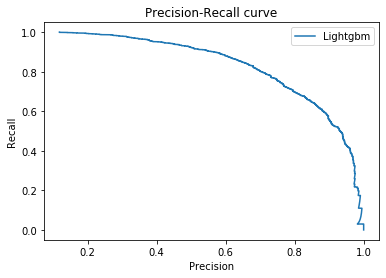

In [397]:
prec, recall, _ = precision_recall_curve(all_probs_valid['target'],valid_pred)
plt.title('Precision-Recall curve')
plt.plot(prec,recall,label='Lightgbm')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend()
print('AUC: ',auc(recall,prec))

    That certainly is a great boost in the performance! the gap between ROC and Precision-Recall curves has been bridged... or is it really? Honestly, I belive our model is doing worse than before for 2 reasons, could you think of any?

    Here goes:
    - This is an overfit since we are calculating the probabilities for validation set based on the target from validation itself
    - Virtually this probability translates to the target without any intermediate but still our model could only get 84% auc
    
    Irrespective of how the model performed, it is us who missed a tiny yet important detail - in the validation set we have a target and hence calculated probabilities are based on target itself. But, when this model is deployed we get the features but not target. So, what we should have done is translate the probabilites from training set to the validation and test sets so as to avoid overfit.

In [458]:
all_probs = pd.DataFrame()
columns = train_data.columns.drop(['target', 'mean', 'std', 'min', 'max','skew', 'kurtosis'])
for col in columns:
    all_probs[['prob_'+col,'bin_'+col]] = get_probabilities(train_data[[col,'target']])

all_probs = all_probs.astype('float32')
all_probs['target'] = train_data['target']

In [460]:
all_probs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162000 entries, 134138 to 15339
Columns: 401 entries, prob_var_0 to target
dtypes: float32(400), int16(1)
memory usage: 248.7 MB


In [436]:
def translate_probabilities(df):
    '''Identifies the bin from train probabilities(all_probs - global variable) and assigns the same probability to 
    df[var]'''
    columns = df.columns.drop(['target', 'mean', 'std', 'min', 'max','skew', 'kurtosis'])
    for var in columns:
        n = len(df[var])
        iqr = df[var].quantile([.75]).values - df[var].quantile([.25]).values
        bin_size = 2.5*iqr/n**(1/3) #Freedman-Diaconis rule to define the bin size
        bins = int((max(df[var]) - min(df[var]))/bin_size)

        df['bin_'+var] = pd.cut(df[var],bins=bins,labels=range(bins)).astype('float32')
        
        map_dict = dict(zip(all_probs['bin_'+var],all_probs['prob_'+var]))
        df['prob_'+var] = df['bin_'+var].replace(map_dict)
    
    return df.loc[:,'prob_var_0':]

In [457]:
all_probs_valid = translate_probabilities(valid_data.copy(deep=True))
all_probs_valid.astype('float32')
all_probs_valid['target'] = valid_data['target']


In [461]:
#let's define train_d and val_d again
train_d = Dataset(all_probs[all_probs.iloc[:,0::+2].columns.drop('target')],label=all_probs['target'])
val_d = Dataset(all_probs_valid[all_probs_valid.iloc[:,0::+2].columns],label=all_probs_valid['target'],reference=train_d)


In [462]:
start = time.time()
params = {'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 5}

lgb = lightgbm.train(params= params,
                     train_set= train_d,
                     valid_sets= val_d,
                     early_stopping_rounds=30,
                     num_boost_round=2000)

end = time.time()
print('Time taken in sec: ',end-start)

[1]	valid_0's auc: 0.481336
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.468184
[3]	valid_0's auc: 0.466539
[4]	valid_0's auc: 0.459291
[5]	valid_0's auc: 0.453451
[6]	valid_0's auc: 0.450118
[7]	valid_0's auc: 0.455277
[8]	valid_0's auc: 0.459877
[9]	valid_0's auc: 0.465253
[10]	valid_0's auc: 0.469696
[11]	valid_0's auc: 0.469689
[12]	valid_0's auc: 0.466501
[13]	valid_0's auc: 0.467652
[14]	valid_0's auc: 0.472229
[15]	valid_0's auc: 0.47263
[16]	valid_0's auc: 0.470558
[17]	valid_0's auc: 0.468901
[18]	valid_0's auc: 0.475558
[19]	valid_0's auc: 0.478188
[20]	valid_0's auc: 0.478661
[21]	valid_0's auc: 0.478614
[22]	valid_0's auc: 0.478552
[23]	valid_0's auc: 0.478514
[24]	valid_0's auc: 0.480235
[25]	valid_0's auc: 0.483304
[26]	valid_0's auc: 0.485724
[27]	valid_0's auc: 0.488013
[28]	valid_0's auc: 0.486473
[29]	valid_0's auc: 0.486572
[30]	valid_0's auc: 0.487248
[31]	valid_0's auc: 0.485837
[32]	valid_0's auc: 0.484262
[33]	valid_0's auc: 0

In [463]:
valid_pred = lgb.predict(all_probs_valid[all_probs_valid.iloc[:,0::+2].columns])
roc_auc_score(all_probs_valid['target'],valid_pred)

0.49524654642082616

AUC:  0.10214988406781379


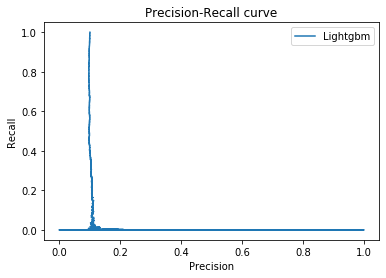

In [464]:
prec, recall, _ = precision_recall_curve(all_probs_valid['target'],valid_pred)
plt.title('Precision-Recall curve')
plt.plot(prec,recall,label='Lightgbm')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend()
print('AUC: ',auc(recall,prec))

    There it is! the original picture: after translating the probabilities to validation set performance became worse than ever

### Conclusion:
    
    This has proved that our idea of considering bin probabilities was a successful failure. It's successful because we have tried a new out-of-the box method for feature engineering yet a failure because it couldn't improve our model performance. Hence we would stick to our earlier version of lightgbm with roc_auc_score: 88, auc of precision_recall: 57 and try to improve it.
    
    why do you think we would prefer going back to the model with roc_auc 88 and precision_recall: 57?

    Even though the precision-recall is not very high, this produces the best trade-off between roc and precision_recall scores we've had till now
    
    There is still lots of room for improvement like using a more complex model, tune hyperparameters, more feature engineering, playing around with anonymous data etc., the idea of this notebook is to give an insider view at understanding the process and developing the idea but not to underline a solution as the best. The process of modeling is iterative, involves lots of experimentation.